I have recently moved from Pune to Delhi. I had spent only a year in Pune, having moved there from Mumbai, where I lived for three years. Whenever I move, the bulk of my luggage consists of books and clothes. My stay in Pune was just a transition, so I never bothered to unpack and store all my stuff too carefully. Thus, a corner of my bedroom in my Pune apartment always looked like this:

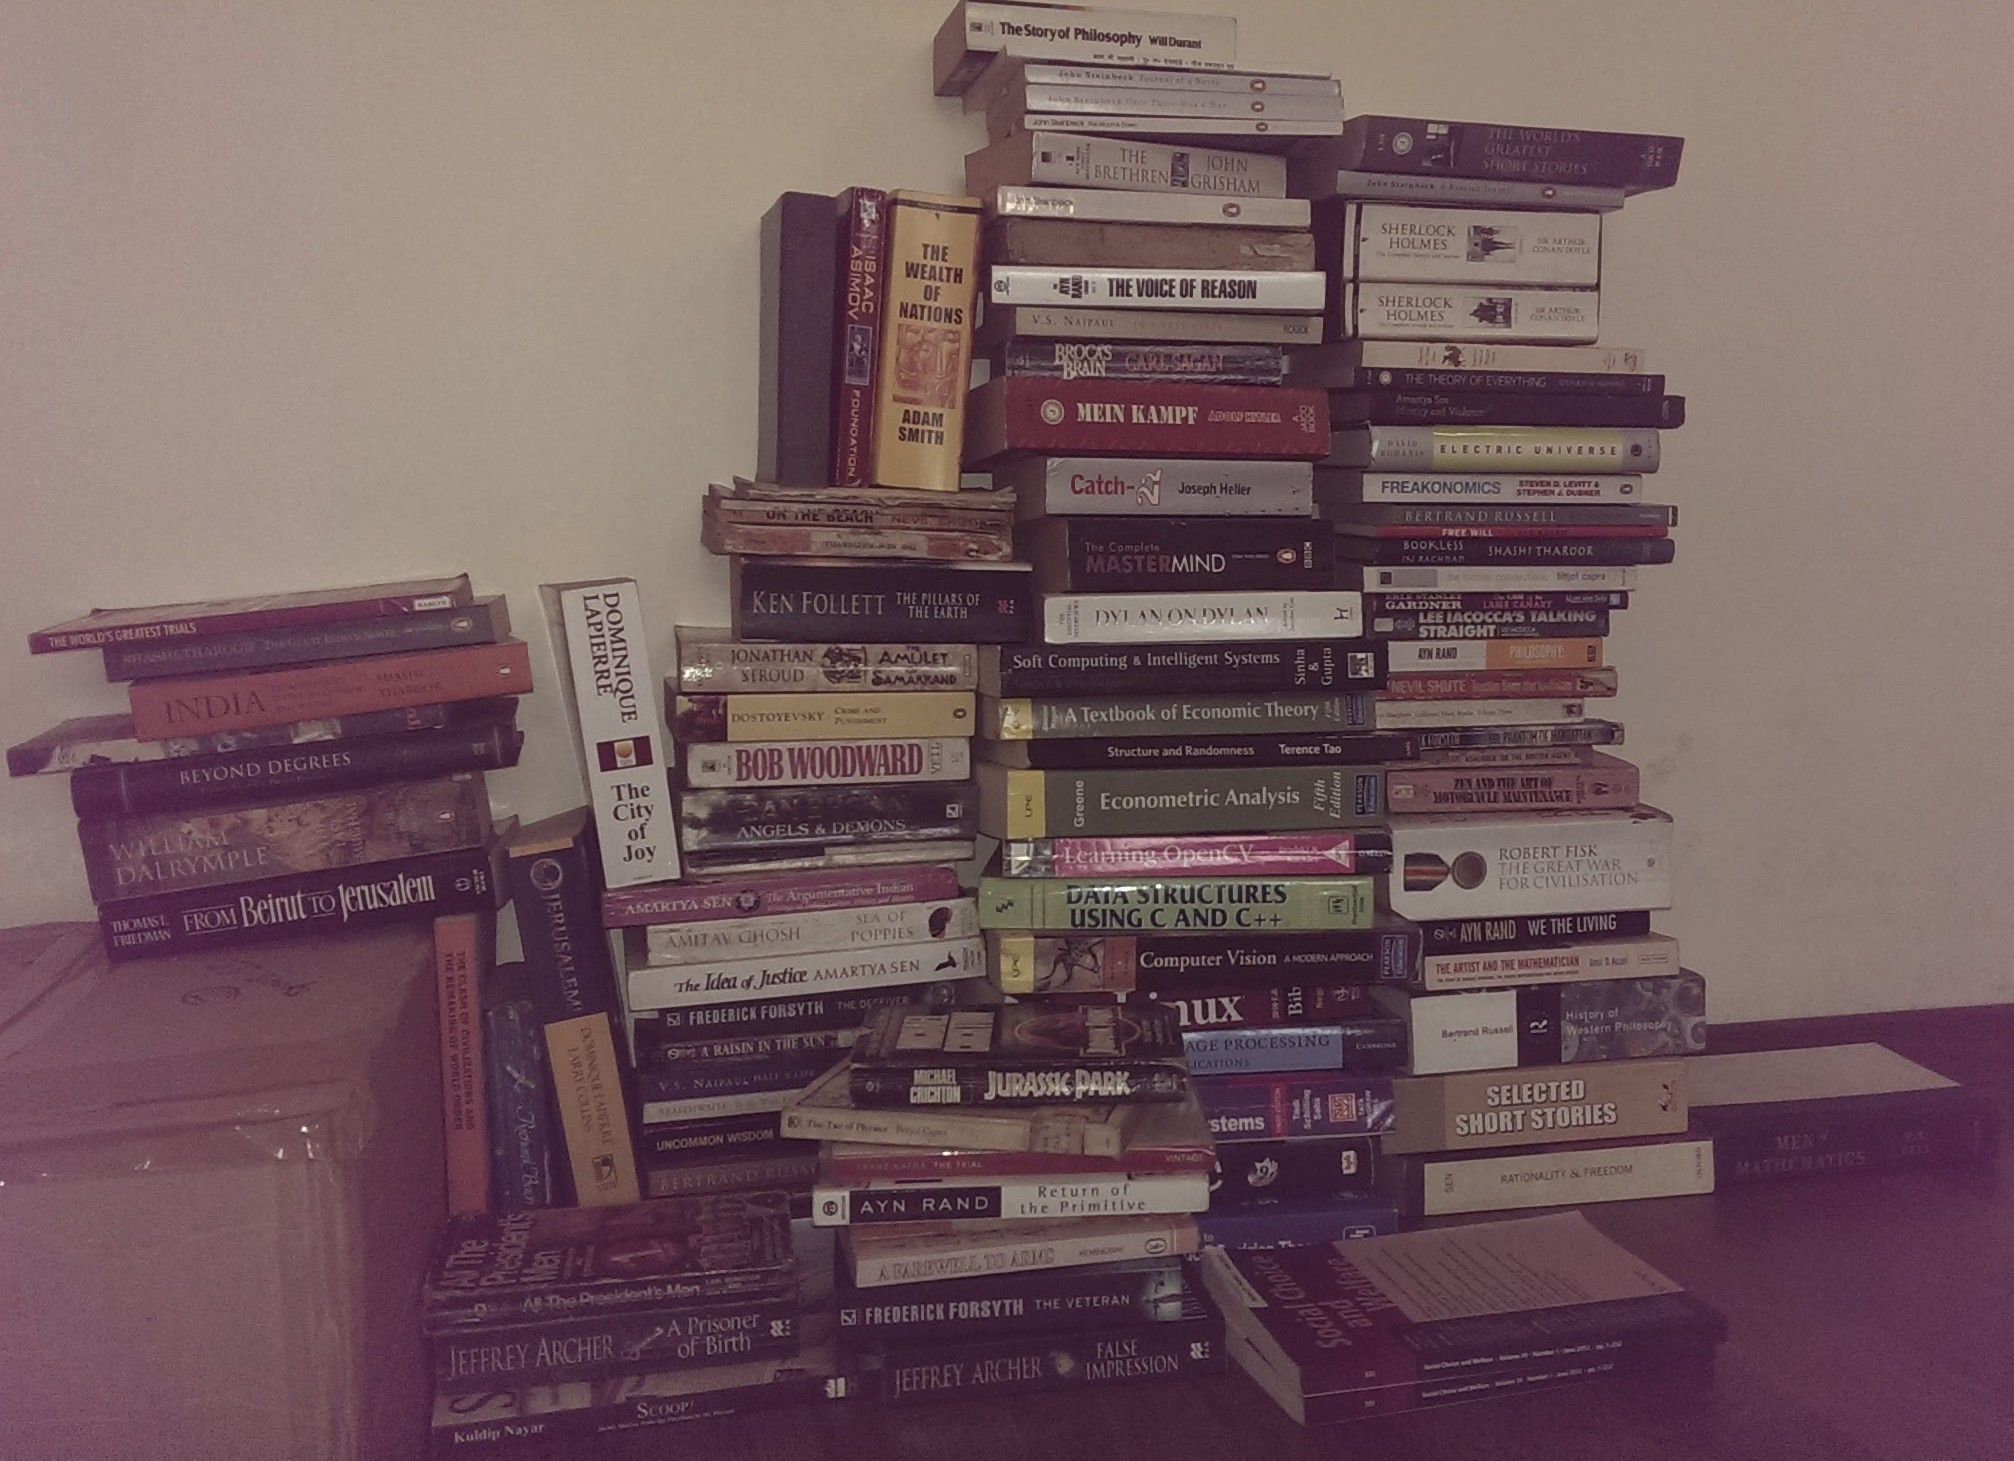

In [1]:
from IPython.display import Image
Image('images/before.jpg', height=300, width=400)

The actual volume of books that I carried from Pune to Delhi is about twice of what is seen in the picture. My house in Delhi has six bookshelves, three in the living room and three in another room that I've made into a study. Naturally, I wanted to arrange my nearly 200 books in a manner that would be convenient to access, and such that the arrangement made some thematic sense. For example, I should not have to go to the living room to get one of my books on data analysis, and my partner shouldn't have to keep coming into the study to get one of her novels. Also, books that deal with similar subjects should naturally lie together. Obviously, arraging books semantically and such that they look good on the shelves isn't a data analysis problem as such, and even a haphazard, arbitrary arrangement of books would still work well for most practical purposes, but I still thought making it data driven would be a fun exercise.
<!-- TEASER_END -->

An obvious method was to arrange the books alphabetically, but I rejected that for two reasons. First, there are some books that one identifies by the name of the author instead of by the title (for example, "Wes McKinney's book on Pandas" is easier for me to remember than "Python for Data Analysis"). Therefore, the immediate question was whether to sort alphabetically the names of the authors or the titles of the book. Secondly, even if I picked one of these attributes by which to arrange the books, that would make the arrangement look physically very ugly. It would also not ensure that books with similar themes or genres lie together. (I would not have [_Computer Vision: A Modern Approach_ by Forsyth and Ponce](http://www.amazon.com/Computer-Vision-Modern-Approach-Edition/dp/013608592X) positioned next to [_The Day of the Jackal_ by Fredrick Forsyth](http://www.amazon.com/Day-Jackal-Frederick-Forsyth/dp/0451239377))

I also briefly considered using the Dewey Decimal System, but it became quickly apparent that it is only worthwhile for huge libraries, and sometimes not even then. So after a bit of thinking, I laid down the following rules that the arrangement should follow:

1. Books should be arranged by height
2. Books by the same author should be positioned next to each other.
3. A shelf should house at most two genres of books.

Since I had six bookshelves, it seemed natural that I should partition titles into six clusters in an unsupervised manner.

Getting and Preprocessing the Data
---------------------------------------

To perform clustering on the book titles, I started annotating books by the names of their author, their height in millimeters and there genres and subgenres. The resulting dataset is available [here](https://gist.githubusercontent.com/jaidevd/23aef12e9bf56c618c41/raw/c05e98672b8d52fa0cb94aad80f75eb78342e5d4/books_new.csv), and looks somewhat like this:

In [2]:
import pandas as pd
url = "https://gist.githubusercontent.com/jaidevd/23aef12e9bf56c618c41/raw/c05e98672b8d52fa0cb94aad80f75eb78342e5d4/books_new.csv"
df = pd.read_csv(url, index_col='Title')
df.head()

,Author,Genre,SubGenre,Height,Publisher
Title,,,,,
Fundamentals of Wavelets,"Goswami, Jaideva",tech,signal_processing,228,Wiley
Data Smart,"Foreman, John",tech,data_science,235,Wiley
God Created the Integers,"Hawking, Stephen",tech,mathematics,197,Penguin
Superfreakonomics,"Dubner, Stephen",science,economics,179,HarperCollins
Orientalism,"Said, Edward",nonfiction,history,197,Penguin


For convenience, I ignored the first names of the authors. I also only considered the last names of the first author of those books that have multiple authors.

In [3]:
df['Author'] = df['Author'].astype(str).apply(lambda x: x.split(',')[0].lower())

The author, genre and subgenre of the books are categorical variables, so they have to be converted into dummy numerical variables first, and then the height attribute has to be added to the resulting dataset.

In [4]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer

# Get dummy vectors for categorical data
authorVect = DictVectorizer(sparse=False)
dummyAuthors = authorVect.fit_transform([dict(author=f) for f in df['Author']])
genreVect = DictVectorizer(sparse=False)
dummyGenres = genreVect.fit_transform([dict(genre=f) for f in df['Genre']])
subgenVect = DictVectorizer(sparse=False)
dummySubGenres = subgenVect.fit_transform([dict(subgen=f) for f in df['SubGenre']])

X = np.c_[dummyAuthors, dummyGenres, dummySubGenres]

# Add height to the dataset
X = np.c_[X, df['Height'].values]

Analysis and Visualization
------------------------------

Before the clustering, let's run a basic PCA reduction on the dataset and take a look at the scatterplot. Let's also create a convex hull around the scatter plot and take a look at which book titles make up the vertices of the hull.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

In [7]:
# Standard normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dimensionality reduction
pca = PCA(n_components=2)
x_red = pca.fit_transform(X)

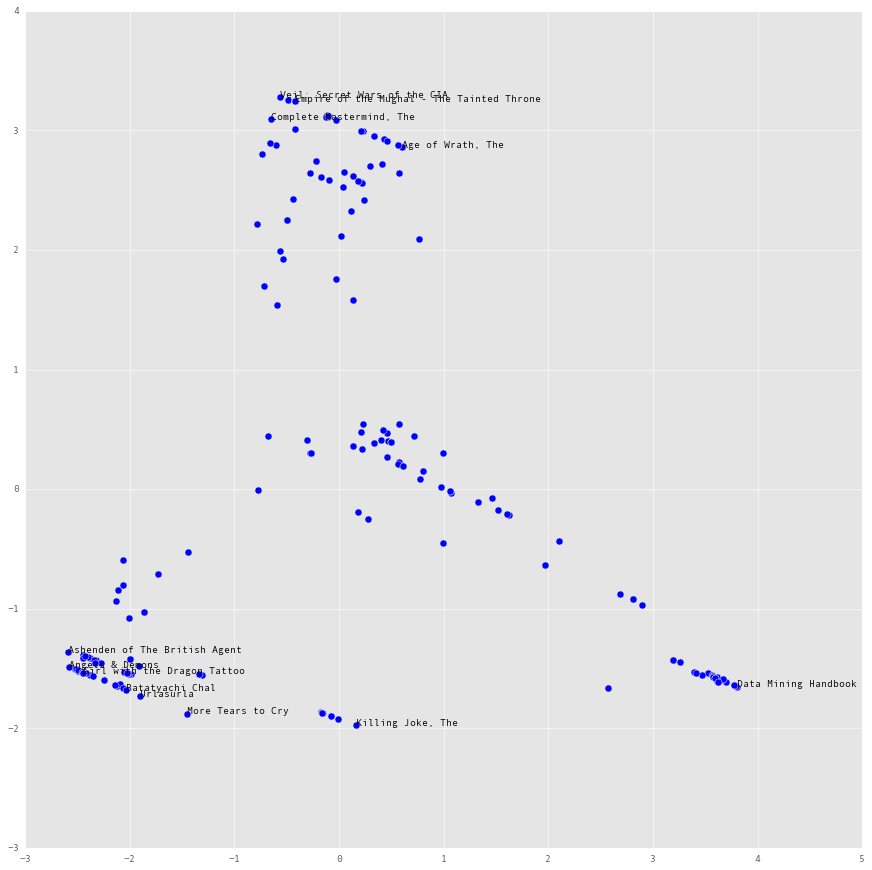

In [8]:
hull = ConvexHull(x_red)
plt.figure(figsize=(15, 15))
plt.scatter(x_red[:, 0], x_red[:, 1], s=50)
for vertex in hull.vertices:
    plt.annotate(df.index[vertex], xy=x_red[vertex, :])

At this stage the scatter plot looks like it is making sense. The cluster at the top right seems like the fiction cluster, the one at the top center might be graphic novels and the one at the bottom might be history. There is still some ambiguity, as the plot says nothing about which attributes are varying as we move away from the origin towards the vertices of the hull.

To examine the variation among the attributes in detail, let's use a biplot superimposed on the scatterplot. Let's also perform the clustering with KMeans, with six centroids, each denoting a shelf.

In [9]:
from sklearn.cluster import KMeans

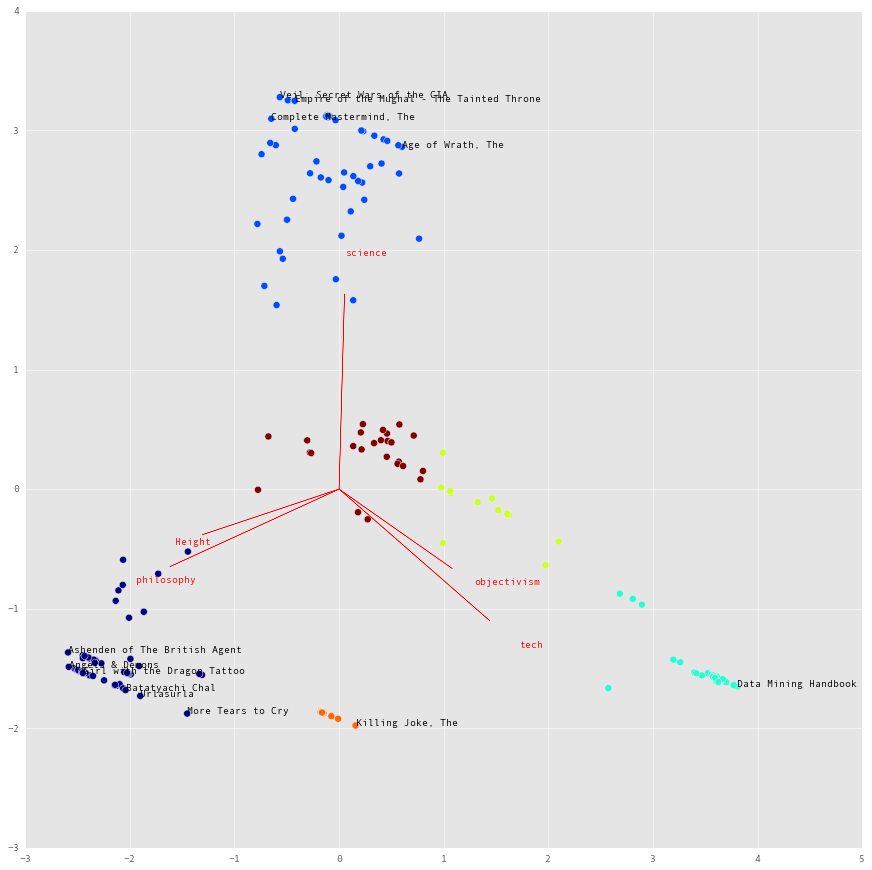

In [10]:
km = KMeans(n_clusters=6, n_jobs=-1)
clusters = km.fit_predict(x_red)

xvector = pca.components_[0]
yvector = pca.components_[1]

xs = pca.transform(X)[:,0]
ys = pca.transform(X)[:,1]



columns = df.Author.unique().tolist() + \
          df.Genre.unique().tolist() + \
          df.SubGenre.unique().tolist() + ['Height']

plt.figure(figsize=(15, 15))

# Creating the biplot
mXS, mYS = xs.max(), ys.max()
xVec, yVec = xvector * mXS, yvector * mYS
largeAttrs = np.sqrt(xVec ** 2 + yVec ** 2)
maxAttrs = np.argsort(largeAttrs)[::-1][:10]
for i in range(5):
    plt.arrow(0, 0, -xvector[maxAttrs[i]]*max(xs), yvector[maxAttrs[i]]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(-xvector[maxAttrs[i]]*max(xs)*1.2, yvector[maxAttrs[i]]*max(ys)*1.2,
             columns[maxAttrs[i]], color='r')

plt.scatter(xs, ys, c=clusters, s=50)

for vertex in hull.vertices:
    plt.annotate(df.index[vertex], xy=x_red[vertex, :])

The lines denote how the different attributes of the book vary among the titles, and the six colored clusters are how I arranged my books among the six shelves. After the arragement dictated by the clustering output, they looked a bit better:

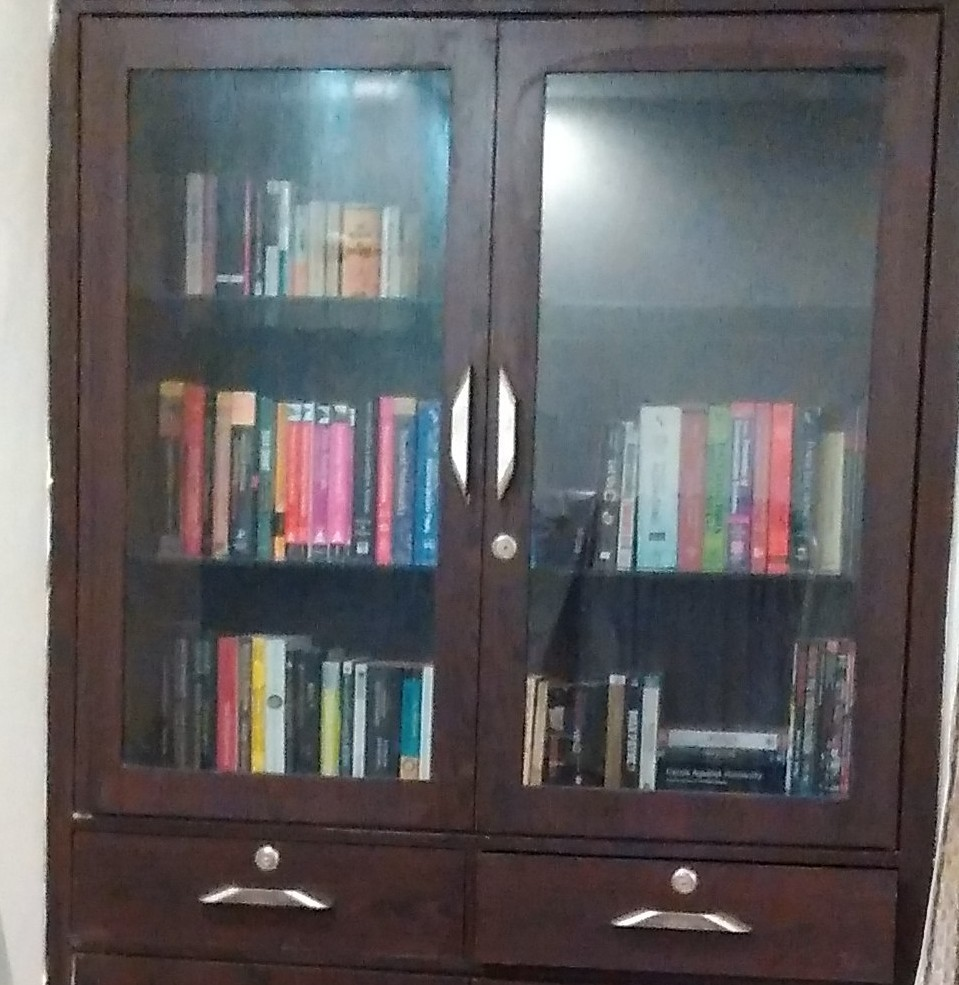

In [11]:
Image('images/shelf1.jpg', height=300, width=400)

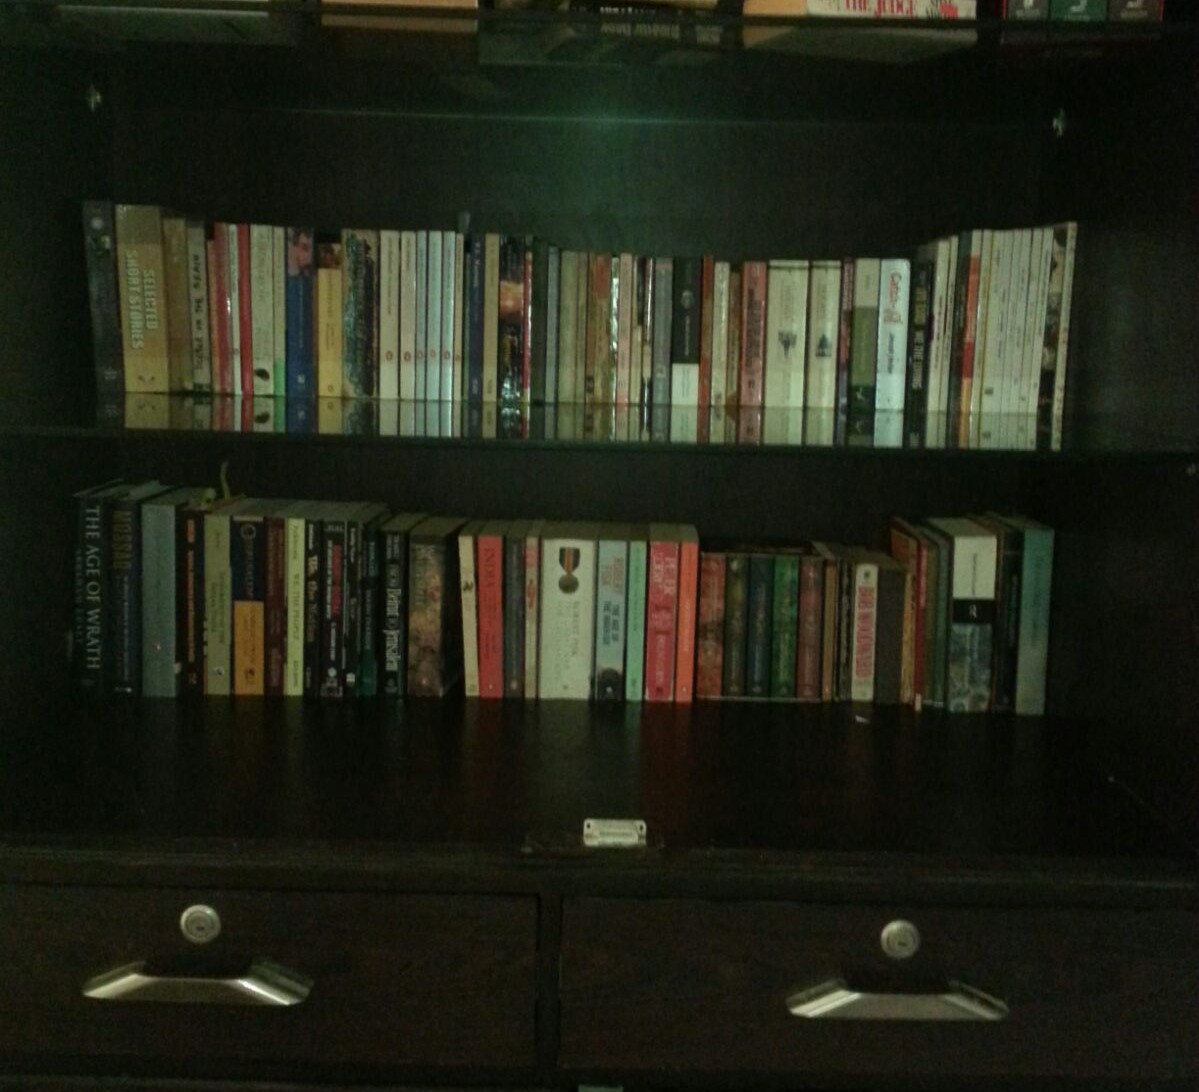

In [12]:
Image('images/shelf2.jpg', height=300, width=400)

I might have gone quite overboard with personal data analytics with this exercise, but at least I learnt how to make biplots. The kitchen is next.